In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt

In [ ]:
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,  
    width_shift_range=0.20,  
    height_shift_range=0.20,
    zoom_range=0.20,
    brightness_range=[0.8, 1.2], 
    shear_range=0.1,  
    channel_shift_range=10.0
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    'Final_dataset/train',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_gen = test_datagen.flow_from_directory(
    'Final_dataset/val',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)
test_gen = test_datagen.flow_from_directory(
    'Final_dataset/test',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3000 images belonging to 3 classes.
Found 1050 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers

# BASE MODEL
baseModel = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)
total_layers = len(baseModel.layers)
for idx, layer in enumerate(baseModel.layers):
    if idx > 0.80 * total_layers: 
        layer.trainable = True
    else:
        layer.trainable = False

2025-05-03 07:40:24.845334: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-03 07:40:24.845384: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-03 07:40:24.845395: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-03 07:40:24.845446: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-03 07:40:24.845460: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam

# Custom head
model = models.Sequential([
    baseModel,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='swish'),  
    layers.Dropout(0.6),
    layers.Dense(256, activation='swish'),
    layers.Dropout(0.6),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  #
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,051,075 (11.64 MB)

 Trainable params: 2,316,931 (8.84 MB)

 Non-trainable params: 734,144 (2.80 MB)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.ModelCheckpoint(
        'MobiletNet.keras',
        save_best_only=True,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-5
    )
]

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

/Users/rajendarbore/Desktop/Sasi_Final/Skin_Env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-05-03 07:40:29.730664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


94/94 ━━━━━━━━━━━━━━━━━━━━ 91s 832ms/step - accuracy: 0.4328 - loss: 1.6678 - val_accuracy: 0.5676 - val_loss: 1.0974 - learning_rate: 1.0000e-04
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 69s 724ms/step - accuracy: 0.5913 - loss: 1.2407 - val_accuracy: 0.6514 - val_loss: 1.0400 - learning_rate: 1.0000e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 64s 675ms/step - accuracy: 0.5967 - loss: 1.2014 - val_accuracy: 0.6657 - val_loss: 1.1353 - learning_rate: 1.0000e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 67s 701ms/step - accuracy: 0.6702 - loss: 0.9904 - val_accuracy: 0.7181 - val_loss: 0.9301 - learning_rate: 1.0000e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 63s 660ms/step - accuracy: 0.6570 - loss: 0.9786 - val_accuracy: 0.7114 - val_loss: 0.8977 - learning_rate: 1.0000e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 697ms/step - accuracy: 0.7118 - loss: 0.8901 - val_accuracy: 0.7629 - val_loss: 0.7522 - learning_rate: 1.0000e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 66s 692ms/step - accuracy: 0.72

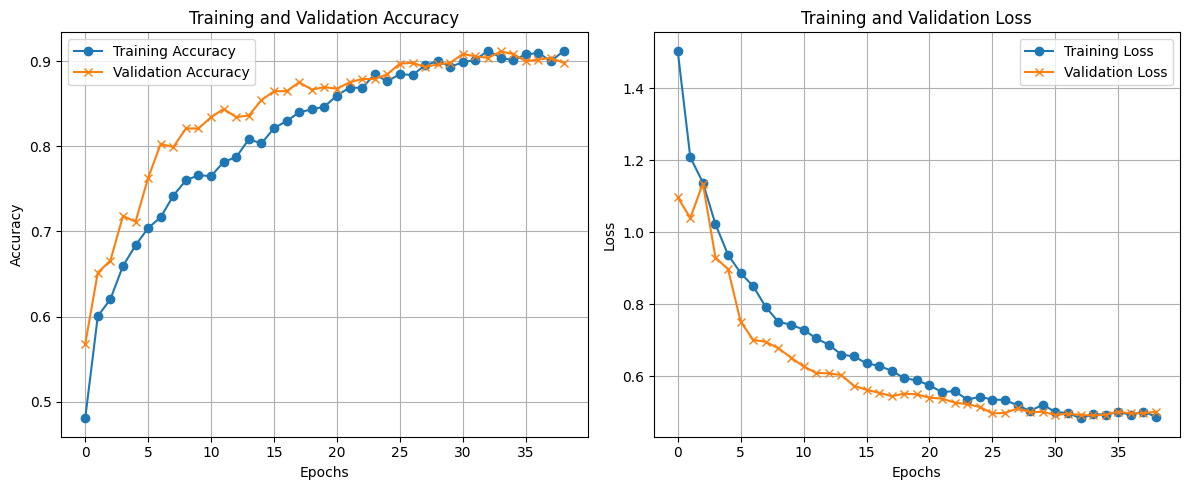

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']
loss =  history.history['loss']
val_loss =  history.history['val_loss']
epochs_range = range(len(acc))

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='x')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='x')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(test_gen)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


/Users/rajendarbore/Desktop/Sasi_Final/LatestSkinVENV/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-05-04 13:40:05.311172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - accuracy: 0.9104 - loss: 0.4887
Test Loss: 0.5100
Test Accuracy: 88.67%


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
Y_pred = model.predict(test_gen, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

# True labels
y_true = test_gen.classes

# Class labels
class_labels = list(test_gen.class_indices.keys())

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step


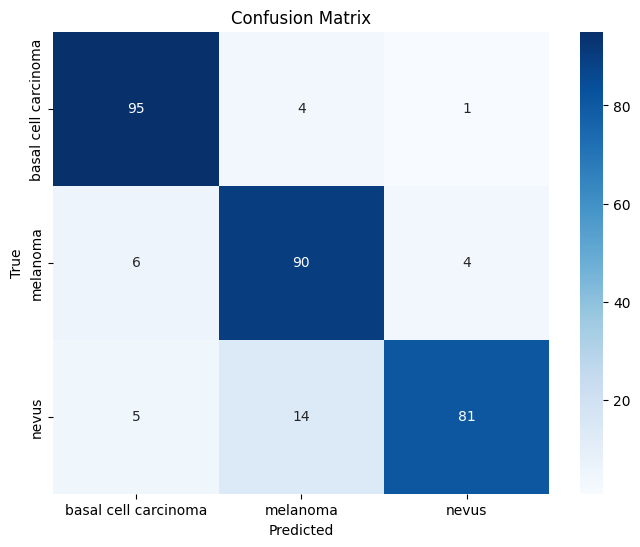

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:

                      precision    recall  f1-score   support

basal cell carcinoma       0.90      0.95      0.92       100
            melanoma       0.83      0.90      0.87       100
               nevus       0.94      0.81      0.87       100

            accuracy                           0.89       300
           macro avg       0.89      0.89      0.89       300
        weighted avg       0.89      0.89      0.89       300



In [ ]:
macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')
print(f"Macro F1-Score: {macro_f1:.4f}")
print(f"Weighted F1-Score: {weighted_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")

Macro F1-Score: 0.8862
Weighted F1-Score: 0.8862
Macro Precision: 0.8905
Macro Recall: 0.8867



Class-wise AUC Scores:
basal cell carcinoma: 0.9876
melanoma: 0.9617
nevus: 0.9693

Macro-average AUC: 0.9722


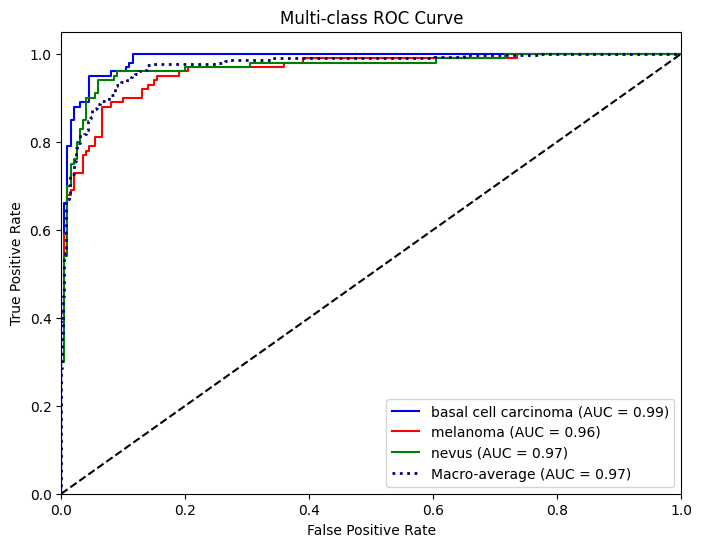

In [ ]:
from sklearn.preprocessing import label_binarize
n_classes = len(class_labels) 

y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["macro"], tpr["macro"], _ = roc_curve(y_true_bin.ravel(), Y_pred.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print("\nClass-wise AUC Scores:")
for i in range(n_classes):
    print(f"{class_labels[i]}: {roc_auc[i]:.4f}")

print(f"\nMacro-average AUC: {roc_auc['macro']:.4f}")

plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')  

plt.plot(fpr["macro"], tpr["macro"],
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=2)


plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right") 
plt.show()
